In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest
from matplotlib.colors import LinearSegmentedColormap

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import optimize, stats

import nilearn
from nilearn import plotting
from nilearn import masking
from nilearn.input_data import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# import pingouin as pg

import random
# from random import random as rand

import re

/home/sungbeenpark/.local/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
def fast_masking(img, roi):
    ## img : data (NIFTI image)
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    if img_data.shape != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
    ## the shape is (n_trials, n_voxels) which is to cross-validate for runs. =(n_samples, n_features)
    return img_data[roi_mask]

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [5]:
def get_x_center(X, N, nth):
    return X-0.5 + (nth+0.5)/(N+2)

In [6]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root, 'stats')
dir_mask = join(dir_root, 'masks')

In [7]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '50', '51', '53'
    , '54', '55'
]

In [8]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

---
---

# 20230116

In [9]:
glm, stat = 'GLM.reward_per_trial', 'Rew'
# glm, stat = 'GLM.movement', 'Cursor'

# glm, stat = '3dREMLfit.reward_per_trial', 'Rew'

---

caudate 4 parts

In [9]:
fname_roi = join(dir_mask, 'mask.caudate_4parts.nii')
label_roi = ['rhCA', 'lhCA', 'lbCA', 'rbCA']
img1 = nilearn.image.load_img(fname_roi)

putamen 4 parts

In [10]:
fname_roi = join(dir_mask, 'mask.separated_putamen.GP.nii')
label_roi = ['rAPU', 'laPU', 'lpPU', 'rpPU']
img2 = nilearn.image.load_img(fname_roi)

In [11]:
img_roi = nilearn.image.math_img(img1=img1, img2=img2, formula='img1 + img2*10')
label_roi = ['rhCA', 'lhCA', 'lbCA', 'rbCA', 'raPU', 'laPU', 'lpPU', 'rpPU']

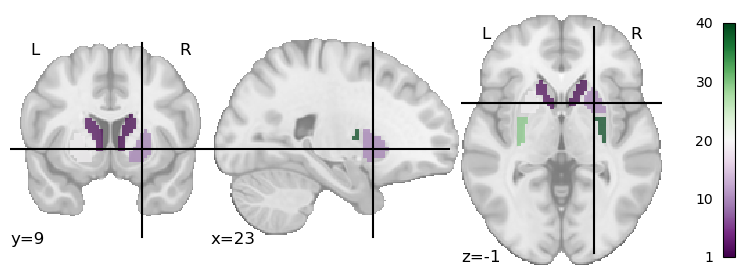

In [12]:
plotting.plot_roi(
    img_roi
    , colorbar=True, cmap='PRGn'
)

In [13]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_roi
    , memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=label_roi
)
value_rois = masker.labels_img.get_fdata().astype(int)

In [15]:
np.unique(img_roi.get_data())

/tmp/ipykernel_1666941/2842760190.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  np.unique(img_roi.get_data())


array([ 0,  1,  2,  3,  4, 10, 20, 30, 40], dtype=int16)

---

Sum 'mask.caudate_4parts.nii' and 'mask.separated_putamen.GP.nii'

In [12]:
fname_roi = join(dir_mask, 'mask.sum.caudate_4parts.separated_putamen.nii')
label_roi = ['rA', 'lA', 'lpPU', 'rpPU', 'lpCA', 'rpCA']
img_roi = nilearn.image.load_img(fname_roi)

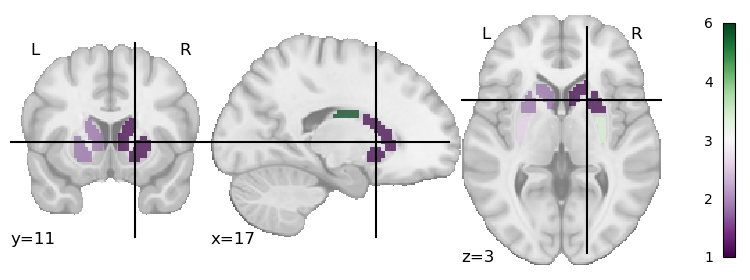

In [13]:
plotting.plot_roi(
    img_roi
    , colorbar=True, cmap='PRGn'
)

In [14]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_roi
    , memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=label_roi
)
value_rois = masker.labels_img.get_fdata().astype(int)

---

straitum's 7 subregions

In [15]:
fname_roi = join(dir_mask, 'mask.straitum-con-7sub.resampled.nii')
label_roi = ['Limbic', 'Executive', 'Rostral-motor', 'Caudal-motor', 'Parietal', 'Occipital', 'Temporal']

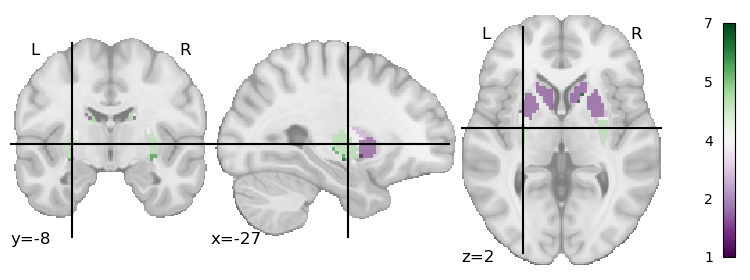

In [16]:
plotting.plot_roi(
    fname_roi
    , colorbar=True, cmap='PRGn'
)

In [17]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=nilearn.image.load_img(fname_roi)
    , memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=label_roi
)
value_rois = masker.labels_img.get_fdata().astype(int)

---

GP

In [15]:
df = pd.DataFrame(columns=['subj', 'group', 'stim_region', 'ROI', 'nvoxels', 'shift', 'feature'])
for kk, shift in enumerate([0, 2.5, 5]):
    
    list_fname = sorted(glob(join(
        dir_stat, 'AM/%s/%.1fs_shifted'%(glm,shift), 'GP??/%s#1_Coef.nii'%stat
    )))
    print('len(list_data)=%d'%len(list_fname))

    for ii, fname in enumerate(tqdm(list_fname)):
        subj = fname.split('/')[-2]
        nn = subj[2:]
        features = masker.fit_transform(fname)
        group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('dlPFC_20Hz' if nn in list_dlPFC_20Hz else ('M1_cTBS' if nn in list_M1_cTBS else 'invalid'))
        region = 'M1' if 'M1' in group else ('dlPFC' if 'dlPFC' in group else 'invalid')
        for jj, roi in enumerate(masker.labels):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'stim_region':region
                    , 'ROI':roi, 'nvoxels':value_rois[value_rois==jj+1].astype(bool).sum()
                    , 'shift':'%.1fs'%shift, 'feature':features[0][jj]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )

len(list_data)=46


100%|██████████| 46/46 [00:10<00:00,  4.21it/s]


len(list_data)=46


100%|██████████| 46/46 [00:10<00:00,  4.44it/s]


len(list_data)=46


100%|██████████| 46/46 [00:10<00:00,  4.50it/s]


GA

In [16]:
for kk, shift in enumerate([0, 2.5, 5]):
    list_fname = sorted(glob(join(
            '/mnt/ext5/GA/fmri_data/stats'
            , 'AM/%s/%.1fs_shifted'%(glm, shift), 'GA??/%s#1_Coef.nii'%stat
        )))
    print('len(list_data)=%d'%len(list_fname))

    for ii, fname in enumerate(tqdm(list_fname)):
        subj = fname.split('/')[-2]
        nn = subj[2:]
        features = masker.fit_transform(fname)
        group = 'GA'
        region = 'None'
        for jj, roi in enumerate(masker.labels):
            new_row = pd.Series(
                {
                    'subj':subj, 'group':group, 'stim_region':region
                    , 'ROI':roi, 'nvoxels':value_rois[value_rois==jj+1].astype(bool).sum()
                    , 'shift':'%.1fs'%shift, 'feature':features[0][jj]
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T]
                , axis='index'
                , ignore_index=True
            )

len(list_data)=30


100%|██████████| 30/30 [00:06<00:00,  4.39it/s]


len(list_data)=30


100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


len(list_data)=30


100%|██████████| 30/30 [00:06<00:00,  4.50it/s]


In [110]:
# fig, ax = plt.subplots(nrows=1, figsize=(5,4))

# ylabel = fname.split('/')[-1].split('.')[0]
# for shift in [5]:
# #     g = sns.boxplot(
# #         data=df[df['shift']=='%.1fs'%shift], x='group', y='feature', hue='ROI'
# #         , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
# #         , whis=[0, 100], width=.6
# #         , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
# #         , ax=ax
# #     )
#     g = sns.barplot(
#         data=df[df['shift']=='%.1fs'%shift], x='group', y='feature', hue='ROI'
#         , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
#         , palette=sns.color_palette("Paired", len(df.ROI.unique()))
#         , errorbar='se', capsize=0.1
#         , ax=ax
#     )
    
# #     g.get_legend().remove()
#     g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# #     g.set(ylim=[-0.1, 0.5])
#     g.grid(axis='y')
#     g.set_ylabel(ylabel, fontsize=12, rotation=90)
# #     g.set(ylim=[-1.5, 1])
# #     g.set_ylim(-2,10)
# #     g.hlines(0, xmin=-1, xmax=4, colors='yellow', linestyle='--', linewidth=2)
#     g.set_xlabel('')
#     g.set_title('%ss_shifted'%shift)

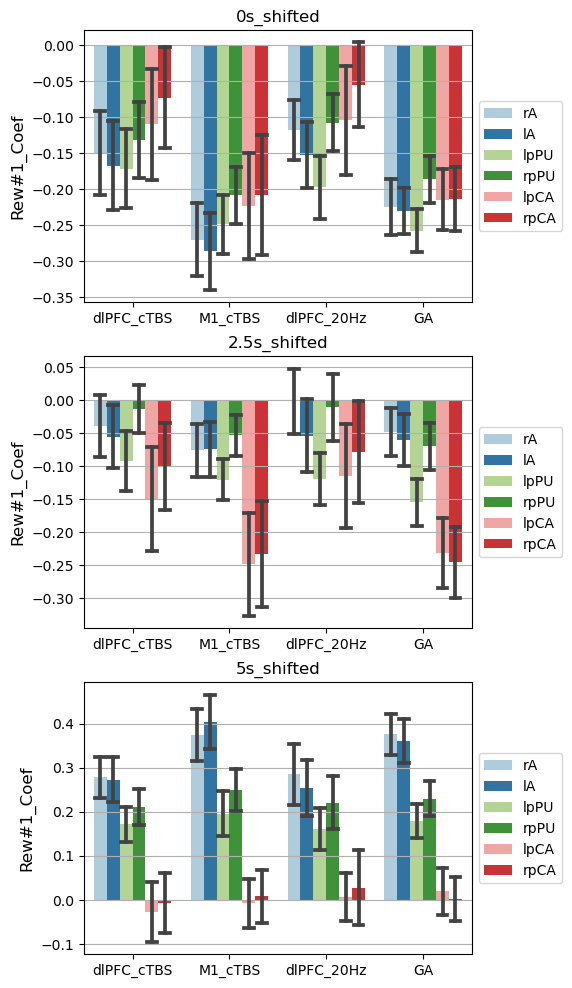

In [53]:
fig, axs = plt.subplots(nrows=3, figsize=(5,4*3))

ylabel = fname.split('/')[-1].split('.')[0]
for kk, shift in enumerate([0, 2.5, 5]):
    ax = axs[kk]
#     g = sns.boxplot(
#         data=df[df['shift']=='%.1fs'%shift], x='group', y='feature', hue='ROI'
#         , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
#         , whis=[0, 100], width=.6
#         , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
#         , ax=ax
#     )
    g = sns.barplot(
        data=df[df['shift']=='%.1fs'%shift], x='group', y='feature', hue='ROI'
        , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz', 'GA')
        , palette=sns.color_palette("Paired", len(df.ROI.unique()))
        , errorbar='se', capsize=0.1
        , ax=ax
    )
    
#     g.get_legend().remove()
    g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
#     g.set(ylim=[-0.1, 0.5])
    g.grid(axis='y')
    g.set_ylabel(ylabel, fontsize=12, rotation=90)
#     g.set(ylim=[-1.5, 1])
#     g.set_ylim(-2,10)
#     g.hlines(0, xmin=-1, xmax=4, colors='yellow', linestyle='--', linewidth=2)
    g.set_xlabel('')
    g.set_title('%ss_shifted'%shift)

In [54]:
s = '%.1fs'%5
print('time shift = %s'%s)
g1, g2 = 'dlPFC_cTBS', 'M1_cTBS'
print("%s vs. %s"%(g1, g2))
for roi in label_roi:
# for roi in ['Limbic', 'Executive']:
    ### paired t-test
    a = df[(df.group==g1)&(df.ROI==roi)&(df['shift']==s)].feature
    b = df[(df.group==g2)&(df.ROI==roi)&(df['shift']==s)].feature
    tval, pval = stats.ranksums(a,b,alternative='less')
    print("%s:"%roi, "%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))

time shift = 5.0s
dlPFC_cTBS vs. M1_cTBS
rA: 0.1043 (ns)
lA: 0.0474 (*)
lpPU: 0.3087 (ns)
rpPU: 0.3210 (ns)
lpCA: 0.2401 (ns)
rpCA: 0.3210 (ns)


In [55]:
## dlPFC_cTBS vs. M1_cTBS (roi: rhCA)
s = '%.1fs'%5
g1, g2 = 'dlPFC_cTBS', 'M1_cTBS'
roi = 'lA'

a = df[(df.group==g1)&(df.ROI==roi)&(df['shift']==s)].feature
b = df[(df.group==g2)&(df.ROI==roi)&(df['shift']==s)].feature
tval, pval = stats.ranksums(a,b,alternative='less')

ax = axs[2]

N = len(label_roi)
X_m = 0
X_nth = get_x_center(X_m, N, 2)
yUEdge = 0.55
yApart = 0.025
ax.plot([X_nth, X_nth], [a.mean()+(a.sem()+yApart), yUEdge], 'k-')
ax.plot([X_nth+1, X_nth+1], [b.mean()+(b.sem()+yApart), yUEdge], 'k-')
ax.plot([X_nth, X_nth+1], [yUEdge, yUEdge], 'k-')
ax.text(
    X_nth+0.5, yUEdge+(0.02), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)
ax.set_ylim(-0.13, 0.64)

(-0.13, 0.64)

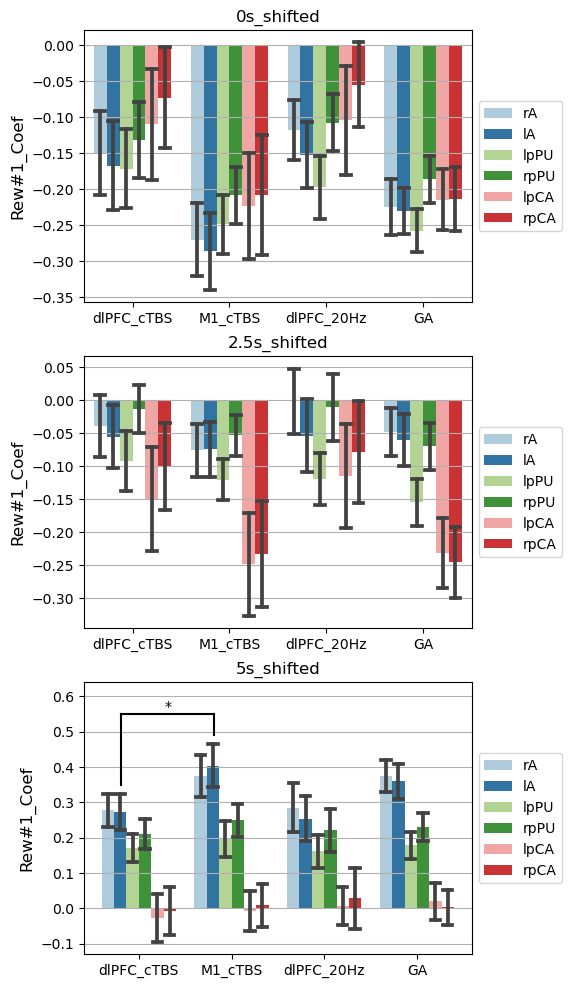

In [56]:
fig

In [27]:
s = '%.1fs'%5
print('time shift = %s'%s)
g1, g2 = 'dlPFC_cTBS', 'GA'
print("%s vs. %s"%(g1, g2))
for roi in label_roi:
# for roi in ['Limbic', 'Executive']:
    ### paired t-test
    a = df[(df.group==g1)&(df.ROI==roi)&(df['shift']==s)].feature
    b = df[(df.group==g2)&(df.ROI==roi)&(df['shift']==s)].feature
    tval, pval = stats.ranksums(a,b,alternative='greater')
    print("%s:"%roi, "%.4f (%s)"%(pval,convert_pvalue_to_asterisks(pval)))

time shift = 5.0s
dlPFC_cTBS vs. GA
rhCA: 0.8883 (ns)
lhCA: 0.8180 (ns)
lbCA: 0.8659 (ns)
rbCA: 0.7100 (ns)
raPU: 0.7873 (ns)
laPU: 0.9310 (ns)
lpPU: 0.5616 (ns)
rpPU: 0.5088 (ns)


In [20]:
# dx = 0.2

# ax = axs[2]

# x1 = 0
# x2 = 1
# ## LV line
# ax.plot([x1-(2-0.5)*dx, x2-(2-0.5)*dx], [(a.mean()+a.sem(), b.mean+b.sem()), a.mean()], 'k-')

# ## RV line

# ## H line

# # ax.text(
# #     xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
# #     , ha='center', va='center', rotation=90, size=10

In [57]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/barplot.%s.%s1_Coef.striatum_clumsy.png'%(glm, stat)
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GP/results/barplot.GLM.reward_per_trial.%s1_Coef.striatum.png'%stat
#     , dpi=300, facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

---
---

### 7 localizers (from GA)

In [10]:
list_roi = glob(join('/mnt/ext5/NAS05/GA/fmri_data/masks/localizer/n200_c*.nii'))
rois = []
for fname in list_roi:
    rois.append('_'.join(fname.split('/')[-1].split('.')[0].split('_')[2:4]))
print(rois)

[]


In [9]:
img_rois = nilearn.image.math_img(img1=list_roi[0], formula='img1*0')
for ii, fname in enumerate(list_roi):
    img_rois = nilearn.image.math_img(img1=img_rois, img2=fname, formula='img1 + ((img2>0)*%d)'%(ii+1))

IndexError: list index out of range

#### top 3

In [18]:
img_rois = nilearn.image.load_img(glob(join('/home/sungbeenpark/tmp/mask.localizer3.GA.nii')))
rois = ['L_M1', 'c1', 'c2']

### 7 localizers (from GP)

In [12]:
list_roi = glob(join('/mnt/ext5/GP/fmri_data/masks/GLM.move-stop/n*.nii'))

rois = []
for fname in list_roi:
    rois.append(fname.split('/')[-1].split('.')[1])
print(rois)

['L_cerebellum_VI', 'L_thalamus', 'SMA', 'L_putamen', 'R_cerebellum_IV-V', 'L_M1', 'R_cerebellum_VIIIb']


In [13]:
img_rois = nilearn.image.math_img(img1=list_roi[0], formula='img1*0')
for ii, fname in enumerate(list_roi):
    img_rois = nilearn.image.math_img(img1=img_rois, img2=fname, formula='img1 + ((img2>0)*%d)'%(ii+1))

### Hippocampus 4 parts

In [19]:
img_rois = nilearn.image.load_img(join(dir_mask, 'mask.fan280.hippocampus_4parts.nii'))
rois = ['lrHP', 'rrHP', 'lcHP', 'rcHP']

### Anterior Hippocampus

In [21]:
img_rois = nilearn.image.load_img(join(dir_mask, 'mask.anterior_hippocampus-NAc.nii'))
rois = ['lNAc', 'rNAc', 'laHP', 'raHP']

### VmPFC

In [23]:
img_rois = nilearn.image.load_img(join(dir_mask, 'mask.cross-section.VmPFC.p=1.e-4.nii'))
rois = ['VmPFC']

---

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



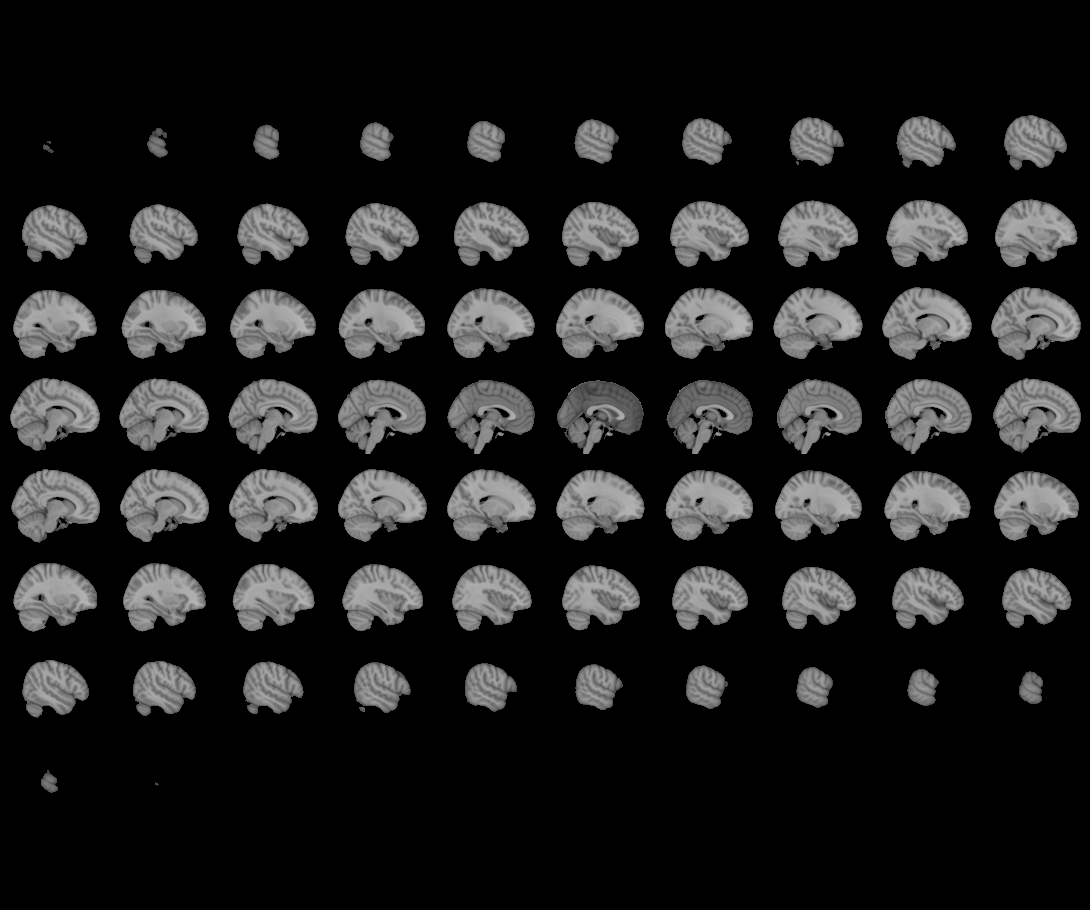
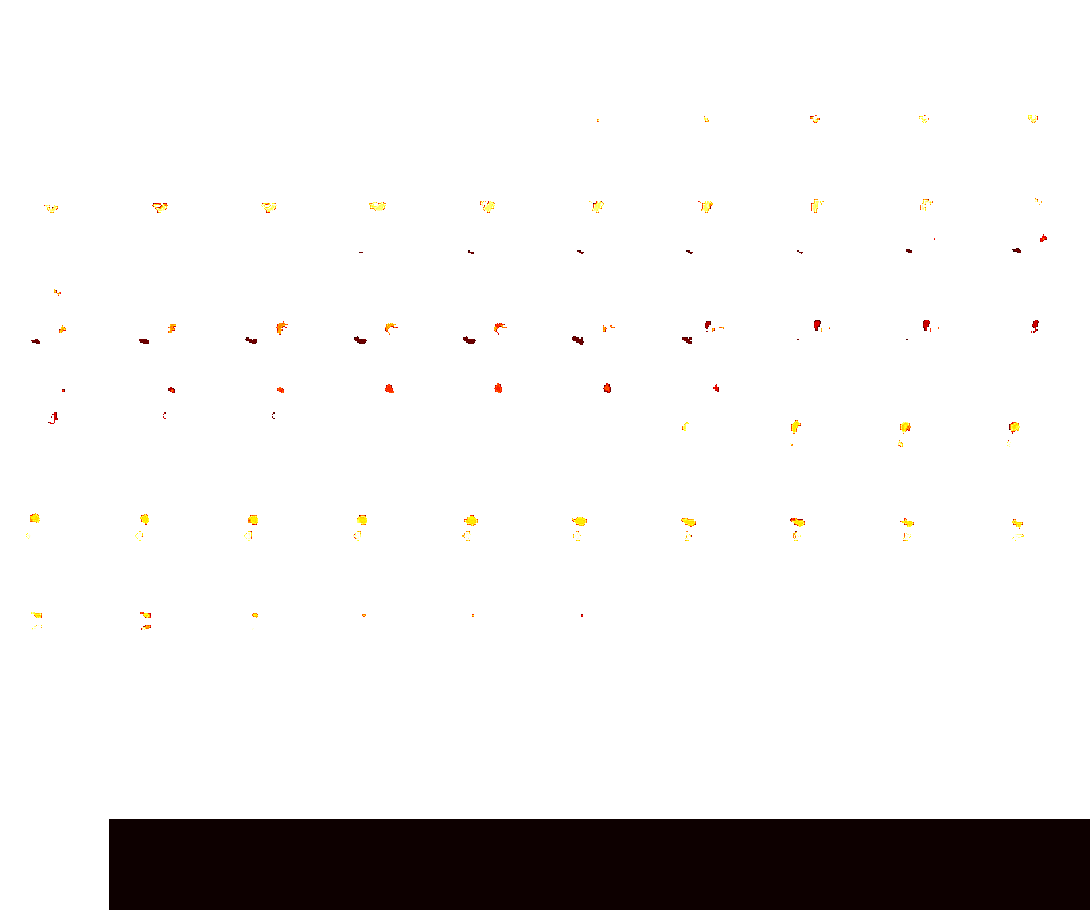

In [16]:
nilearn.plotting.view_img(
    img_rois
    , symmetric_cmap=True
#     , cmap='b'
)

In [17]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_rois, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=rois
)
value_rois = masker.labels_img.get_fdata().astype(int)

---

# Movement

len(list_data)=36


100%|██████████| 36/36 [00:01<00:00, 34.37it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object
len(list_data)=36


100%|██████████| 36/36 [00:01<00:00, 32.77it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object
len(list_data)=36


100%|██████████| 36/36 [00:01<00:00, 34.26it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object


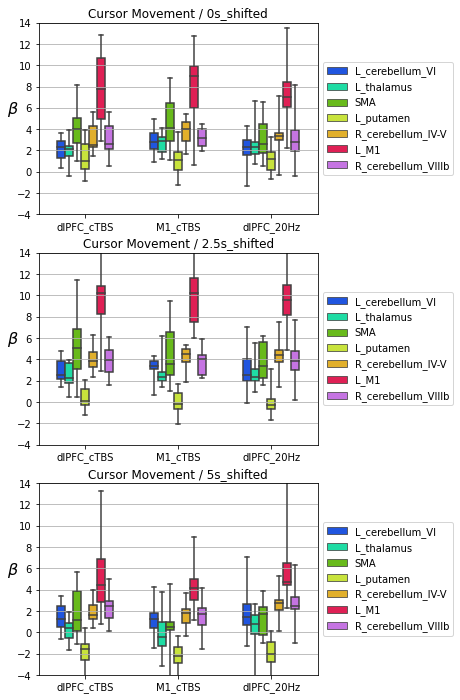

In [23]:
fig, axs = plt.subplots(nrows=3, figsize=(5,4*3))
# axs = np.concatenate(axs)

for kk, shift in enumerate(['0', '2.5', '5']):
    ax = axs[kk]
    
    list_data = sorted(glob(join(dir_stat, 'GLM.movement.%ss_shifted'%shift, 'GP??/GP??.Length#1_Coef.nii')))
    print('len(list_data)=%d'%len(list_data))

    df = pd.DataFrame(columns=['subj', 'group', 'ROI', 'stim_region', 'beta', 'nvoxels'])

    for ii, datum in enumerate(tqdm(list_data)):
        subj = datum.split('/')[-2]
        nn = subj[-2:]
        betas = masker.fit_transform(datum)
        group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('dlPFC_20Hz' if nn in list_dlPFC_20Hz else ('M1_cTBS' if nn in list_M1_cTBS else 'invalid'))
        region = 'M1' if nn in list_M1_cTBS else 'dlPFC'
        for jj, roi in enumerate(masker.labels):
            df = df.append(
                {'subj':subj, 'group':group, 'ROI':roi, 'stim_region':region, 'beta':betas[0][jj], 'nvoxels':value_rois[value_rois==jj+1].astype(bool).sum()}
                , ignore_index=True
            )

    ## validation check
    print(df[df=='invalid'].sum())
    # df.to_csv('/home/sungbeenpark/Github/labs/GP/results/GLM.movement.7localizers.csv', index=False)
    
#     g = sns.pointplot(
#         data=df, x='group', y='beta', hue='ROI'
#         , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz'), dodge=False
#         , ci=68
# #         , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
#         , capsize=0.12
#         , ax=ax
#     )
    g = sns.boxplot(
        data=df, x='group', y='beta', hue='ROI'
        , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
        , whis=[0, 100], width=.6
        , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
        , ax=ax
    )
    
#     g.get_legend().remove()
    g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
#     g.set(ylim=[-0.1, 0.5])
    g.grid(axis='y')
    g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
    g.set(ylim=[-4, 14])
#     g.set_ylim(-2,10)
#     g.hlines(0, xmin=-1, xmax=4, colors='yellow', linestyle='--', linewidth=2)
    g.set_xlabel('')
    g.set_title('Cursor Movement / %ss_shifted'%shift)

#     fig.savefig(
#         '/home/sungbeenpark/Github/labs/GP/results/pointplot.GLM.movement.7localizers(1).png'
#         , dpi=300, facecolor=[1,1,1,1]
#         , bbox_inches = "tight"
#     )

len(list_data)=36


100%|██████████| 36/36 [00:01<00:00, 32.65it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object
len(list_data)=36


100%|██████████| 36/36 [00:01<00:00, 32.82it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object
len(list_data)=36


100%|██████████| 36/36 [00:01<00:00, 32.78it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object


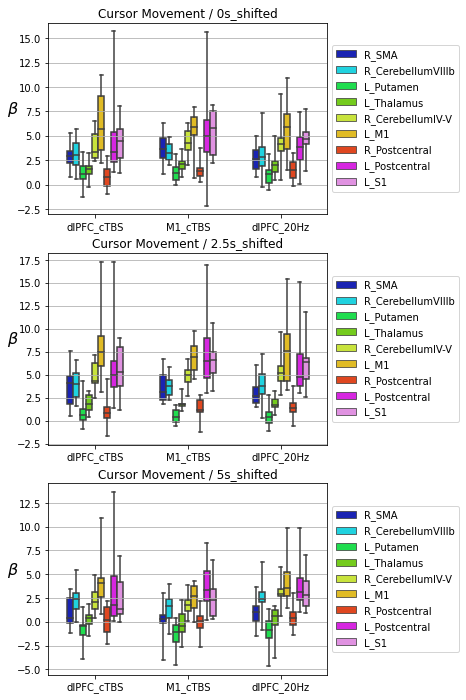

len(list_data)=36


100%|██████████| 36/36 [00:03<00:00,  9.46it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object
len(list_data)=36


100%|██████████| 36/36 [00:03<00:00, 11.49it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object
len(list_data)=36


100%|██████████| 36/36 [00:03<00:00, 11.34it/s]


subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object


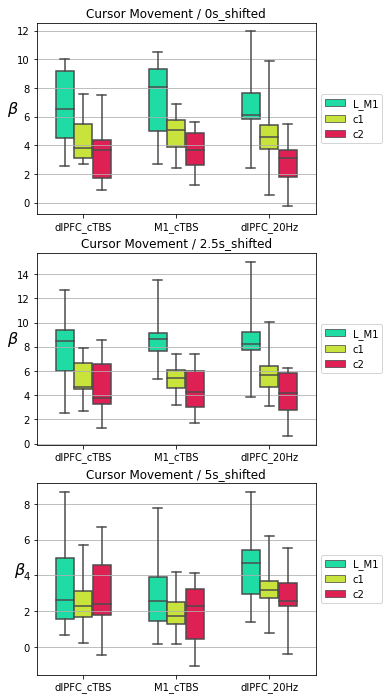

In [33]:
data = df.groupby(['group', 'subj'], as_index=False).mean()
a = data[data.group=='M1_cTBS'].beta
b = data[data.group=='dlPFC_cTBS'].beta

stats.ranksums(a, b )

RanksumsResult(statistic=-0.9814954576223637, pvalue=0.3263484733220724)

In [32]:
pg.kruskal(
        data=df.groupby(['group', 'subj'], as_index=False).mean()
        , dv='beta', between='group'
    )

,Source,ddof1,H,p-unc
Kruskal,group,2,3.463964,0.176933


In [21]:
a = df[(df.ROI=='L_M1')&(df.stim_region=='dlPFC')].beta
b = df[(df.ROI=='L_M1')&(df.stim_region=='M1')].beta
stats.ranksums(a,b)

RanksumsResult(statistic=1.2751965049066463, pvalue=0.20223969808664954)

In [24]:
a = df[(df.ROI=='c1')&(df.stim_region=='dlPFC')].beta
b = df[(df.ROI=='c1')&(df.stim_region=='M1')].beta
stats.ranksums(a,b)

RanksumsResult(statistic=2.013468165642073, pvalue=0.044065400736826854)

In [25]:
a = df[(df.ROI=='c2')&(df.stim_region=='dlPFC')].beta
b = df[(df.ROI=='c2')&(df.stim_region=='M1')].beta
stats.ranksums(a,b)

RanksumsResult(statistic=1.2080808993852439, pvalue=0.22701614597813413)

In [19]:
for ii in masker.labels:
    tmp = pg.kruskal(
        data=df
        , dv='beta'
        , between='group'
    )
    print('ROI = %s'%ii)
    print(tmp)
    print('\n')

ROI = L_M1
        Source  ddof1         H     p-unc
Kruskal  group      2  3.261261  0.195806


ROI = c1
        Source  ddof1         H    p-unc
Kruskal  group      2  6.578078  0.03729


ROI = c2
        Source  ddof1         H     p-unc
Kruskal  group      2  1.513514  0.469186




In [17]:
a = df[(df.ROI=='R_CerebellumVIIIb')&(df.group=='dlPFC_cTBS')].beta
b = df[(df.ROI=='R_CerebellumVIIIb')&(df.group=='M1_cTBS')].beta

stat, pval = stats.ttest_ind(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))
stat, pval = stats.ranksums(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))

pval = 0.22177 ns
pval = 0.24821 ns


---

# Success Rate

### GA (fig. 4) vs. GP

In [113]:
dir_fig4 = '/mnt/ext3/NAS05/GA/fmri_data/stats/fig4/early/'
list_GA = np.array(glob(join(dir_fig4, 'statsRWDtime.GA??.run1to3.SPMG2.nii.gz')))
print(len(list_GA))

list_data = sorted(glob(join('/mnt/ext4/GP/fmri_data/stats/AM/reward', 'GP??/GP??.rwdtm#2_Coef.tlrc.nii')))
print(len(list_data))

30
36


### GP (5s shift)

In [117]:
list_GA = []

list_data = sorted(glob(join('/mnt/ext4/GP/fmri_data/stats/GLM.reward.5s_shifted', 'GP??/GP??.Rew#1_Coef.nii')))
print(len(list_data))

36


In [118]:
df = pd.DataFrame(columns=['subj', 'group', 'ROI', 'stim_region', 'beta', 'nvoxels'])

## GA
# for ii, datum in enumerate(tqdm(list_GA)):
#     subj = datum.split('/')[-1].split('.')[1]
#     betas = masker.fit_transform(datum)
#     for jj, roi in enumerate(masker.labels):
#         df = df.append(
#             {'subj':subj, 'group':'None', 'ROI':roi, 'stim_region':'None', 'beta':betas[0][jj], 'nvoxels':value_rois[value_rois==jj+1].astype(bool).sum()}
#             , ignore_index=True
#         )
    
## GP
for ii, datum in enumerate(tqdm(list_data)):
    subj = datum.split('/')[-2]
    nn = subj[-2:]
    betas = masker.fit_transform(datum)
    group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('dlPFC_20Hz' if nn in list_dlPFC_20Hz else ('M1_cTBS' if nn in list_M1_cTBS else 'invalid'))
    for jj, roi in enumerate(masker.labels):
        df = df.append(
            {'subj':subj, 'group':group, 'ROI':roi, 'stim_region':region, 'beta':betas[0][jj], 'nvoxels':value_rois[value_rois==jj+1].astype(bool).sum()}
            , ignore_index=True
        )
    
## validation check
print(df[df=='invalid'].sum())

df

100%|██████████| 36/36 [00:12<00:00,  2.83it/s]

subj             0
group            0
ROI              0
stim_region      0
beta           0.0
nvoxels          0
dtype: object


,subj,group,ROI,stim_region,beta,nvoxels
0,GP08,M1_cTBS,L_putamen,dlPFC,0.345506,150
1,GP08,M1_cTBS,L_thalamus,dlPFC,-0.207048,100
2,GP08,M1_cTBS,R_cerebellum_IV-V,dlPFC,-0.498443,500
3,GP08,M1_cTBS,R_cerebellum_VIIIb,dlPFC,-0.682908,250
4,GP08,M1_cTBS,L_M1,dlPFC,-1.020705,400
...,...,...,...,...,...,...
247,GP55,dlPFC_20Hz,R_cerebellum_IV-V,dlPFC,-0.563992,500
248,GP55,dlPFC_20Hz,R_cerebellum_VIIIb,dlPFC,-0.541300,250
249,GP55,dlPFC_20Hz,L_M1,dlPFC,-2.234660,400
250,GP55,dlPFC_20Hz,L_cerebellum_VI,dlPFC,-0.472966,200


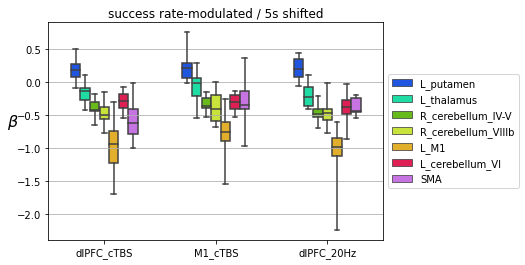

In [119]:
fig, ax = plt.subplots(figsize=(6,4))

g = sns.boxplot(
    data=df, x='group', y='beta', hue='ROI'
    , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
    , whis=[0, 100], width=.6
    , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
)
# g = sns.swarmplot(
#     data=df, x='group', y='beta', hue='ROI'
#     , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
# #     , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
#     , color='k'
# )
# g.get_legend().remove()
g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# g.set(ylim=[-0.1, 0.5])
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
g.set_xlabel('')
g.set_title('success rate-modulated / 5s shifted')

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/boxplot.hippocampus.success_rate-modulated.5s_shifted.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

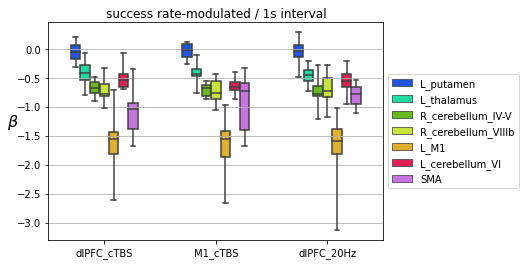

In [115]:
fig, ax = plt.subplots(figsize=(6,4))

g = sns.boxplot(
    data=df, x='group', y='beta', hue='ROI'
    , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
    , whis=[0, 100], width=.6
    , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
)
# g = sns.swarmplot(
#     data=df, x='group', y='beta', hue='ROI'
#     , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
# #     , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
#     , color='k'
# )
# g.get_legend().remove()
g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# g.set(ylim=[-0.1, 0.5])
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
g.set_xlabel('')
g.set_title('success rate-modulated / 1s interval')

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/boxplot.hippocampus.success_rate-modulated.5s_shifted.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

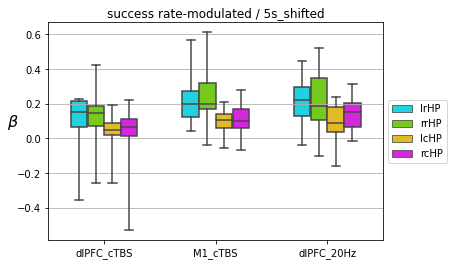

In [14]:
fig, ax = plt.subplots(figsize=(6,4))

g = sns.boxplot(
    data=df, x='group', y='beta', hue='ROI'
    , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
    , whis=[0, 100], width=.6
    , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
)
# g = sns.swarmplot(
#     data=df, x='group', y='beta', hue='ROI'
#     , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
# #     , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
#     , color='k'
# )
# g.get_legend().remove()
g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# g.set(ylim=[-0.1, 0.5])
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
g.set_xlabel('')
g.set_title('success rate-modulated / 5s_shifted')

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/boxplot.hippocampus.success_rate-modulated.5s_shifted.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

In [13]:
list_group = ['dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz']
for roi in masker.labels:
    for ii, g1 in enumerate(list_group[:-1]):
        for g2 in list_group[ii+1:]:
            a = df[(df.ROI==roi)&(df.group==g1)].beta
            b = df[(df.ROI==roi)&(df.group==g2)].beta
            stat, pval = stats.ranksums(a,b)
            print('(%s) %s vs. %s   \t pval=%.3e (%s)'%(roi,g1,g2, pval,convert_pvalue_to_asterisks(pval)))

(lrHP) dlPFC_cTBS vs. M1_cTBS   	 pval=1.659e-01 (ns)
(lrHP) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=1.190e-01 (ns)
(lrHP) M1_cTBS vs. dlPFC_20Hz   	 pval=9.081e-01 (ns)
(rrHP) dlPFC_cTBS vs. M1_cTBS   	 pval=6.467e-02 (ns)
(rrHP) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=3.263e-01 (ns)
(rrHP) M1_cTBS vs. dlPFC_20Hz   	 pval=5.254e-01 (ns)
(lcHP) dlPFC_cTBS vs. M1_cTBS   	 pval=1.489e-01 (ns)
(lcHP) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=2.727e-01 (ns)
(lcHP) M1_cTBS vs. dlPFC_20Hz   	 pval=8.625e-01 (ns)
(rcHP) dlPFC_cTBS vs. M1_cTBS   	 pval=3.556e-01 (ns)
(rcHP) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=1.842e-01 (ns)
(rcHP) M1_cTBS vs. dlPFC_20Hz   	 pval=5.637e-01 (ns)


In [11]:
df = pd.DataFrame(columns=['subj', 'group', 'ROI', 'beta', 'nvoxels'])

## GA
for ii, datum in enumerate(tqdm(list_GA)):
    subj = datum.split('/')[-1].split('.')[1]
    betas = masker.fit_transform(datum)
    group = 'None'
    for jj, roi in enumerate(masker.labels):
        df = df.append(
            {'subj':subj, 'group':group, 'ROI':roi, 'beta':betas[0][jj], 'nvoxels':value_rois.astype(bool).sum()}
            , ignore_index=True
        )
    
## GP
for ii, datum in enumerate(tqdm(list_data)):
    subj = datum.split('/')[-2]
    nn = subj[-2:]
    betas = masker.fit_transform(datum)
    group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('dlPFC_20Hz' if nn in list_dlPFC_20Hz else ('M1_cTBS' if nn in list_M1_cTBS else 'invalid'))
    for jj, roi in enumerate(masker.labels):
        df = df.append(
            {'subj':subj, 'group':group, 'ROI':roi, 'beta':betas[0][jj], 'nvoxels':value_rois.astype(bool).sum()}
            , ignore_index=True
        )
    
## validation check
print(df[df=='invalid'].sum())

df

0it [00:00, ?it/s]
100%|██████████| 36/36 [00:08<00:00,  4.27it/s]

subj         0
group        0
ROI          0
beta       0.0
nvoxels      0
dtype: object


,subj,group,ROI,beta,nvoxels
0,GP08,M1_cTBS,lrHP,0.127410,922
1,GP08,M1_cTBS,rrHP,0.153905,922
2,GP08,M1_cTBS,lcHP,0.062561,922
3,GP08,M1_cTBS,rcHP,0.055478,922
4,GP09,dlPFC_cTBS,lrHP,0.141800,922
...,...,...,...,...,...
139,GP54,dlPFC_20Hz,rcHP,0.163614,922
140,GP55,dlPFC_20Hz,lrHP,0.167514,922
141,GP55,dlPFC_20Hz,rrHP,0.517955,922
142,GP55,dlPFC_20Hz,lcHP,-0.159040,922


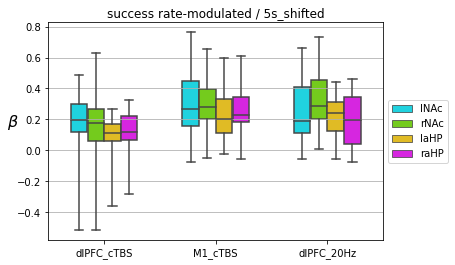

In [15]:
fig, ax = plt.subplots(figsize=(6,4))

g = sns.boxplot(
    data=df, x='group', y='beta', hue='ROI'
    , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
    , whis=[0, 100], width=.6
    , palette=sns.color_palette("gist_ncar", len(df.ROI.unique()))
)
# g = sns.swarmplot(
#     data=df, x='group', y='beta', hue='ROI'
#     , order=('dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
# #     , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
#     , color='k'
# )
# g.get_legend().remove()
g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# g.set(ylim=[-0.1, 0.5])
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
g.set_xlabel('')
g.set_title('success rate-modulated / 5s_shifted')

## t-test


# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GP/results/boxplot.NAc+anterior_hippocampus.success_rate-modulated.5s_shifted.png'
#     , dpi=300, facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

In [40]:
list_group = ['dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz']
for roi in masker.labels:
    for ii, g1 in enumerate(list_group[:-1]):
        for g2 in list_group[ii+1:]:
            a = df[(df.ROI==roi)&(df.group==g1)].beta
            b = df[(df.ROI==roi)&(df.group==g2)].beta
            stat, pval = stats.ranksums(a,b)
            print('(%s) %s vs. %s   \t pval=%.3e (%s)'%(roi,g1,g2, pval,convert_pvalue_to_asterisks(pval)))

(lNAc) dlPFC_cTBS vs. M1_cTBS   	 pval=2.987e-01 (ns)
(lNAc) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=6.442e-01 (ns)
(lNAc) M1_cTBS vs. dlPFC_20Hz   	 pval=5.254e-01 (ns)
(rNAc) dlPFC_cTBS vs. M1_cTBS   	 pval=1.190e-01 (ns)
(rNAc) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=9.407e-02 (ns)
(rNAc) M1_cTBS vs. dlPFC_20Hz   	 pval=7.290e-01 (ns)
(laHP) dlPFC_cTBS vs. M1_cTBS   	 pval=6.467e-02 (ns)
(laHP) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=6.467e-02 (ns)
(laHP) M1_cTBS vs. dlPFC_20Hz   	 pval=1.000e+00 (ns)
(raHP) dlPFC_cTBS vs. M1_cTBS   	 pval=6.467e-02 (ns)
(raHP) dlPFC_cTBS vs. dlPFC_20Hz   	 pval=3.865e-01 (ns)
(raHP) M1_cTBS vs. dlPFC_20Hz   	 pval=4.189e-01 (ns)


In [22]:
pg.anova(
    data=df
    , dv='beta'
    , between=['group']
)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,33,2.878053,0.070448,0.148521


In [23]:
a = df[df.group=='dlPFC_cTBS'].beta
b = df[df.group=='M1_cTBS'].beta

stat, pval = stats.ttest_ind(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))
stat, pval = stats.ranksums(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))

pval = 0.03135 *
pval = 0.02434 *


In [24]:
a = df[df.group=='dlPFC_cTBS'].beta
b = df[df.group=='dlPFC_20Hz'].beta

stat, pval = stats.ttest_ind(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))
stat, pval = stats.ranksums(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))

pval = 0.11673 ns
pval = 0.08326 ns


---

Text(0.5, 1.0, 'Anterior Hippocampus / rew1000')

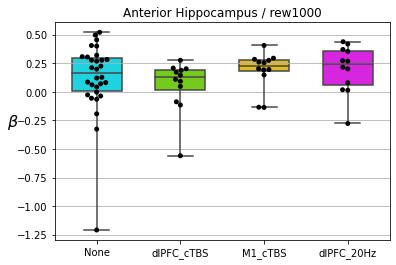

In [13]:
# fig, axs = plt.subplots(ncols=2, figsize=(10,4))

sns.boxplot(
    data=df, x='group', y='beta'
    , order=('None', 'dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
    , whis=[0, 100], width=.6
    , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
)
g = sns.swarmplot(
    data=df, x='group', y='beta'
    , order=('None', 'dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
#     , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
    , color='k'
)
# g.get_legend().remove()
# g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# g.set(ylim=[-0.1, 0.5])
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
g.set_xlabel('')
g.set_title('Anterior Hippocampus / rew1000')

In [14]:
pg.anova(
    data=df
    , dv='beta'
    , between=['group']
)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,62,0.757763,0.522083,0.035369


In [16]:
a = df[df.group=='dlPFC_cTBS'].beta
b = df[df.group=='M1_cTBS'].beta

stat, pval = stats.ttest_ind(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))
stat, pval = stats.ranksums(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))

pval = 0.12077 ns
pval = 0.04965 *


In [17]:
a = df[df.group=='dlPFC_cTBS'].beta
b = df[df.group=='dlPFC_20Hz'].beta

stat, pval = stats.ttest_ind(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))
stat, pval = stats.ranksums(a,b)
print('pval = %.5f'%pval, convert_pvalue_to_asterisks(pval))

pval = 0.12609 ns
pval = 0.09407 ns


---

In [12]:
df = pd.DataFrame(columns=['subj', 'group', 'ROI', 'beta', 'nvoxels'])

## GA
for ii, datum in enumerate(tqdm(list_GA)):
    subj = datum.split('/')[-1].split('.')[1]
    betas = masker.fit_transform(datum)
    group = 'None'
    for jj, roi in enumerate(masker.labels):
        df = df.append(
            {'subj':subj, 'group':group, 'ROI':roi, 'beta':betas[0][jj], 'nvoxels':value_rois.astype(bool).sum()}
            , ignore_index=True
        )
    
## GP
for ii, datum in enumerate(tqdm(list_data)):
    subj = datum.split('/')[-2]
    nn = subj[-2:]
    betas = masker.fit_transform(datum)
    group = 'dlPFC_cTBS' if nn in list_dlPFC_cTBS else ('dlPFC_20Hz' if nn in list_dlPFC_20Hz else ('M1_cTBS' if nn in list_M1_cTBS else 'invalid'))
    for jj, roi in enumerate(masker.labels):
        df = df.append(
            {'subj':subj, 'group':group, 'ROI':roi, 'beta':betas[0][jj], 'nvoxels':value_rois.astype(bool).sum()}
            , ignore_index=True
        )
    
## validation check
print(df[df=='invalid'].sum())

df

100%|██████████| 36/36 [00:05<00:00,  6.84it/s]

subj         0
group        0
ROI          0
beta       0.0
nvoxels      0
dtype: object


,subj,group,ROI,beta,nvoxels
0,GA36,None,VmPFC,0.290900,354
1,GA15,None,VmPFC,0.361266,354
2,GA38,None,VmPFC,0.367646,354
3,GA21,None,VmPFC,-0.084848,354
4,GA18,None,VmPFC,0.404283,354
...,...,...,...,...,...
61,GP50,dlPFC_20Hz,VmPFC,0.337793,354
62,GP51,dlPFC_20Hz,VmPFC,0.452186,354
63,GP53,dlPFC_20Hz,VmPFC,0.508851,354
64,GP54,dlPFC_20Hz,VmPFC,0.249170,354


Text(0.5, 1.0, 'Anterior Hippocampus / rew1000')

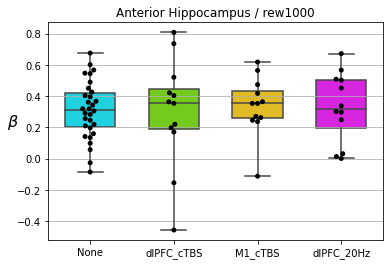

In [19]:
# fig, axs = plt.subplots(ncols=2, figsize=(10,4))

sns.boxplot(
    data=df, x='group', y='beta'
    , order=('None', 'dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
    , whis=[0, 100], width=.6
    , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
)
g = sns.swarmplot(
    data=df, x='group', y='beta'
    , order=('None', 'dlPFC_cTBS', 'M1_cTBS', 'dlPFC_20Hz')
#     , palette=sns.color_palette("gist_ncar", len(df.group.unique()))
    , color='k'
)
# g.get_legend().remove()
# g.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
# g.set(ylim=[-0.1, 0.5])
g.grid(axis='y')
g.set_ylabel(r'$\beta$', fontsize=16, rotation=0)
g.set_xlabel('')
g.set_title('Anterior Hippocampus / rew1000')

In [14]:
pg.anova(
    data=df
    , dv='beta'
    , between=['group']
)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,62,0.074736,0.973355,0.003603


---

### Bootstraping

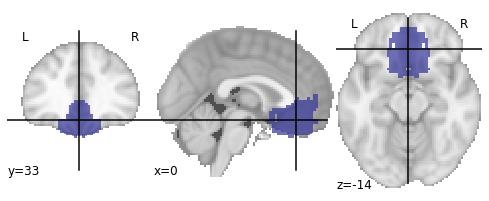

In [9]:
# img_VmPFC = join(dir_mask, 'mask.VmPFC.nii')
img_VmPFC = join(dir_mask, 'mask.VmPFC.all1.nii')
# img_VmPFC = join(dir_mask, 'mask.cross-section.VmPFC.p=1.e-4.nii')
# img_VmPFC = join(dir_mask, 'mask.cross-section.VmPFC.p=1.e-5.nii')
# img_VmPFC = join(dir_mask, 'Clust_mask.VmPFC.p=1e-4.nii')
img_mask=img_VmPFC

# img_mask=nilearn.image.load_img(join(dir_mask, 'HarvardOxford-cort-maxprob-thr25-1mm.nii'))

# img_mask=nilearn.image.load_img(join(dir_mask, 'mask.caudate_4parts.nii'))

nilearn.plotting.plot_roi(
    img_mask
    , cmap='terrain'
#     , cut_coords=(0, 27,-5)
)

In [10]:
img_mask = nilearn.image.load_img(img_VmPFC)

In [11]:
zstat = {}
for fname in list_data:
    subj = fname.split('/')[-1].split('.')[-4]
    
    img_zstat = nilearn.image.load_img(fname)
    zstat[subj] = fast_masking(img=img_zstat, roi=img_mask)

In [12]:
threshold=3.291 # This is a z-score for p=0.001

nvoxel = {}
for subj, zscore in zstat.items():
    nvoxel[subj] = len(zscore[zscore>threshold])

In [13]:
df = pd.DataFrame(columns=['subj', 'group', 'nvoxel'])
for subj, n in nvoxel.items():
    nn = subj[2:]
    group = 'dlPFC_low' if nn in list_low else ('dlPFC_high' if nn in list_high else ('M1' if nn in list_m1 else 'invalid'))

    df = df.append({'subj':subj, 'group':group, 'nvoxel':n}, ignore_index=True)
df

,subj,group,nvoxel
0,GP08,M1,1128
1,GP09,dlPFC_low,339
2,GP10,dlPFC_low,554
3,GP11,M1,1258
4,GP17,M1,269
5,GP18,dlPFC_low,0
6,GP19,M1,46
7,GP20,M1,406
8,GP21,dlPFC_low,312
9,GP22,dlPFC_low,839


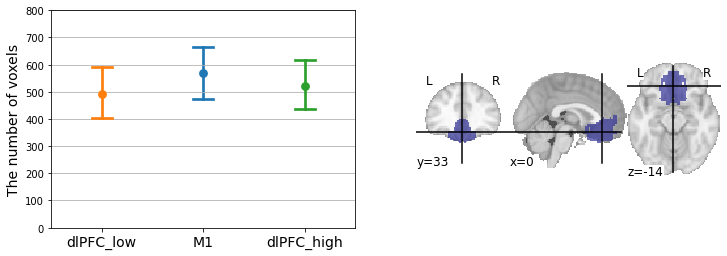

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))

g = sns.pointplot(
    data=df, x='group', y='nvoxel', hue='group'
    , order=('dlPFC_low', 'M1', 'dlPFC_high')
    , capsize=.2, ci=68
    , ax=axs[0]
)
g.get_legend().remove()
g.set(ylim=[0, 800])
g.grid(axis='y')
g.set_ylabel('The number of voxels', fontsize=14)
g.set_xlabel('')
g.set_xticklabels(labels=g.get_xticklabels(),fontsize=14)

nilearn.plotting.plot_roi(
    img_mask
    , cmap='terrain'
    , axes=axs[1]
)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/pointplot.nvoxels.VmPFC.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

In [111]:
df = pd.DataFrame(columns=['group', 'mean_voxel'])

for ii in tqdm(range(10000)):
    ## DLPFC_Low
    list_resampled = random.choices(list_low, k=12)
    tmp = []
    for nn in list_resampled:
        subj = 'GP'+nn
        N = nvoxel[subj]
        tmp.append(N)
    group = 'dlPFC_low' if nn in list_low else ('dlPFC_high' if nn in list_high else ('M1' if nn in list_m1 else 'invalid'))
    mean_voxel = np.mean(tmp)
    df = df.append({'group':group, 'mean_voxel':mean_voxel}, ignore_index=True)
    
    ## DLPFC_M1
    list_resampled = random.choices(list_m1, k=12)
    tmp = []
    for nn in list_resampled:
        subj = 'GP'+nn
        N = nvoxel[subj]
        tmp.append(N)
    group = 'dlPFC_low' if nn in list_low else ('dlPFC_high' if nn in list_high else ('M1' if nn in list_m1 else 'invalid'))
    mean_voxel = np.mean(tmp)
    df = df.append({'group':group, 'mean_voxel':mean_voxel}, ignore_index=True)
    
    ## DLPFC_High
    list_resampled = random.choices(list_high, k=12)
    tmp = []
    for nn in list_resampled:
        subj = 'GP'+nn
        N = nvoxel[subj]
        tmp.append(N)
    group = 'dlPFC_low' if nn in list_low else ('dlPFC_high' if nn in list_high else ('M1' if nn in list_m1 else 'invalid'))
    mean_voxel = np.mean(tmp)
    df = df.append({'group':group, 'mean_voxel':mean_voxel}, ignore_index=True)

df

100%|██████████| 10000/10000 [00:28<00:00, 353.01it/s]


,group,mean_voxel
0,dlPFC_low,554.500000
1,M1,630.500000
2,dlPFC_high,550.500000
3,dlPFC_low,542.416667
4,M1,523.416667
...,...,...
29995,M1,506.666667
29996,dlPFC_high,488.750000
29997,dlPFC_low,517.666667
29998,M1,489.083333


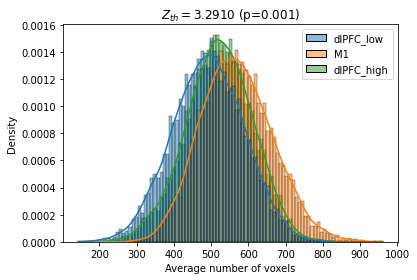

In [156]:
fig, ax = plt.subplots(figsize=(6,4))

g = sns.histplot(
    data=df
    , x='mean_voxel', stat='density', hue='group'
    , kde=True
    , ax=ax
)
ax.legend_.set_title(None)
ax.set_xlabel('Average number of voxels')
ax.set_title(r'$Z_{th}=%.4f$ (p=0.001)'%threshold)

fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/hist.VmPFC.bootstraping.p=0.001.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

In [132]:
a = df[df.group=='dlPFC_low'].mean_voxel
b = df[df.group=='dlPFC_high'].mean_voxel

stats.ttest_ind(a=a, b=b)

Ttest_indResult(statistic=-22.482858177154977, pvalue=1.430774858809742e-110)

---

In [16]:
df = pd.DataFrame(columns=masker.labels)

dir_fig4 = '/mnt/ext5/NAS05/GA/fmri_data/stats/fig4/early/'
list_fig4 = np.array(glob(join(dir_fig4, 'statsRWDtime.GA??.run1to3.SPMG2.nii.gz')))
list_fig4.sort()
for ii, fname in enumerate(list_fig4):
    subj = fname.split('.')[-5]
    df.loc[ii,:] = masker.fit_transform(fname)
df['class'] = 'GA'
df['TMS'] = 'None'
df

,1,class,TMS
0,0.058418,GA,None
1,0.332335,GA,None
2,0.45059,GA,None
3,0.264448,GA,None
4,0.242006,GA,None
5,-0.049278,GA,None
6,0.152228,GA,None
7,0.074101,GA,None
8,-0.029518,GA,None
9,0.114399,GA,None


In [17]:
dg = pd.DataFrame(columns=masker.labels)
TMS = []

list_ = np.array(glob(join(dir_stat, 'AM/reward/GP??/rwdtm-2_Coef.GP??.nii')))
for ii, fname in enumerate(list_):
    subj = fname.split('.')[-2]
    nn = subj[2:]
    if nn in list_DLPFC:
        TMS.append('DLPFC')
    elif nn in list_SHAM:
        TMS.append('SHAM')
    dg.loc[ii,:] = masker.fit_transform(fname)
dg['class'] = 'GP'
dg['TMS'] = TMS
dg

,1,class,TMS
0,0.197639,GP,DLPFC
1,0.36892,GP,SHAM
2,0.333574,GP,DLPFC
3,0.065783,GP,SHAM
4,0.010208,GP,DLPFC
5,0.19665,GP,SHAM
6,0.067889,GP,DLPFC
7,0.367485,GP,DLPFC
8,0.196651,GP,SHAM
9,0.147253,GP,DLPFC


In [18]:
dh = pd.merge(df, dg, how='outer', on=None)
dh

,1,class,TMS
0,0.058418,GA,None
1,0.332335,GA,None
2,0.45059,GA,None
3,0.264448,GA,None
4,0.242006,GA,None
5,-0.049278,GA,None
6,0.152228,GA,None
7,0.074101,GA,None
8,-0.029518,GA,None
9,0.114399,GA,None


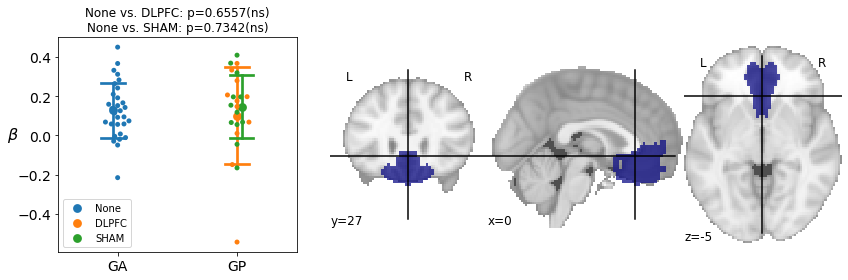

In [21]:
nrows, ncols = len(masker.labels), 3
fig = plt.figure(figsize=(ncols*4, nrows*4), constrained_layout=False)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
for row in range(nrows):
    axs.append(fig.add_subplot(gs[row,0]))
    axs.append(fig.add_subplot(gs[row,1:3]))

for ii, y in enumerate(masker.labels):
    pass_=True
    title=[]
    tval, pval = stats.ttest_ind(dh[dh.TMS=='None'][y], dh[dh.TMS=='DLPFC'][y])
    title.append('None vs. DLPFC: p=%.4f(%s)'%(pval, convert_pvalue_to_asterisks(pval)))
    if pval < 0.05:
        pass_ = False
    tval, pval = stats.ttest_ind(dh[dh.TMS=='None'][y], dh[dh.TMS=='SHAM'][y])
    title.append('None vs. SHAM: p=%.4f(%s)'%(pval, convert_pvalue_to_asterisks(pval)))
    if pval < 0.05:
        pass_ = False
#     if pass_:
#         continue

    ax = axs[2*ii]
    ax = sns.pointplot(
        data=dh, x='class', y=y, hue='TMS'
        , dodge=True
        , capsize=0.2, ci='sd'
        , ax=ax
    )
    ax = sns.swarmplot(
        data=dh, x='class', y=y, hue='TMS'
        , ax=ax
    )
    ax.legend(ax.get_legend_handles_labels()[0][:3], ax.get_legend_handles_labels()[1][:3])
    ax.set(xlabel='', title='%s\n%s'%(title[0],title[1]))
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel(r'$\beta$', fontsize=16, rotation=0)

fig.tight_layout()

for ii, y in enumerate(masker.labels):
    roi = nilearn.image.math_img(img1=img_mask, formula='img1==%d'%int(y))
    nilearn.plotting.plot_roi(roi, cut_coords=(0, 27,-5), axes=axs[2*ii+1])

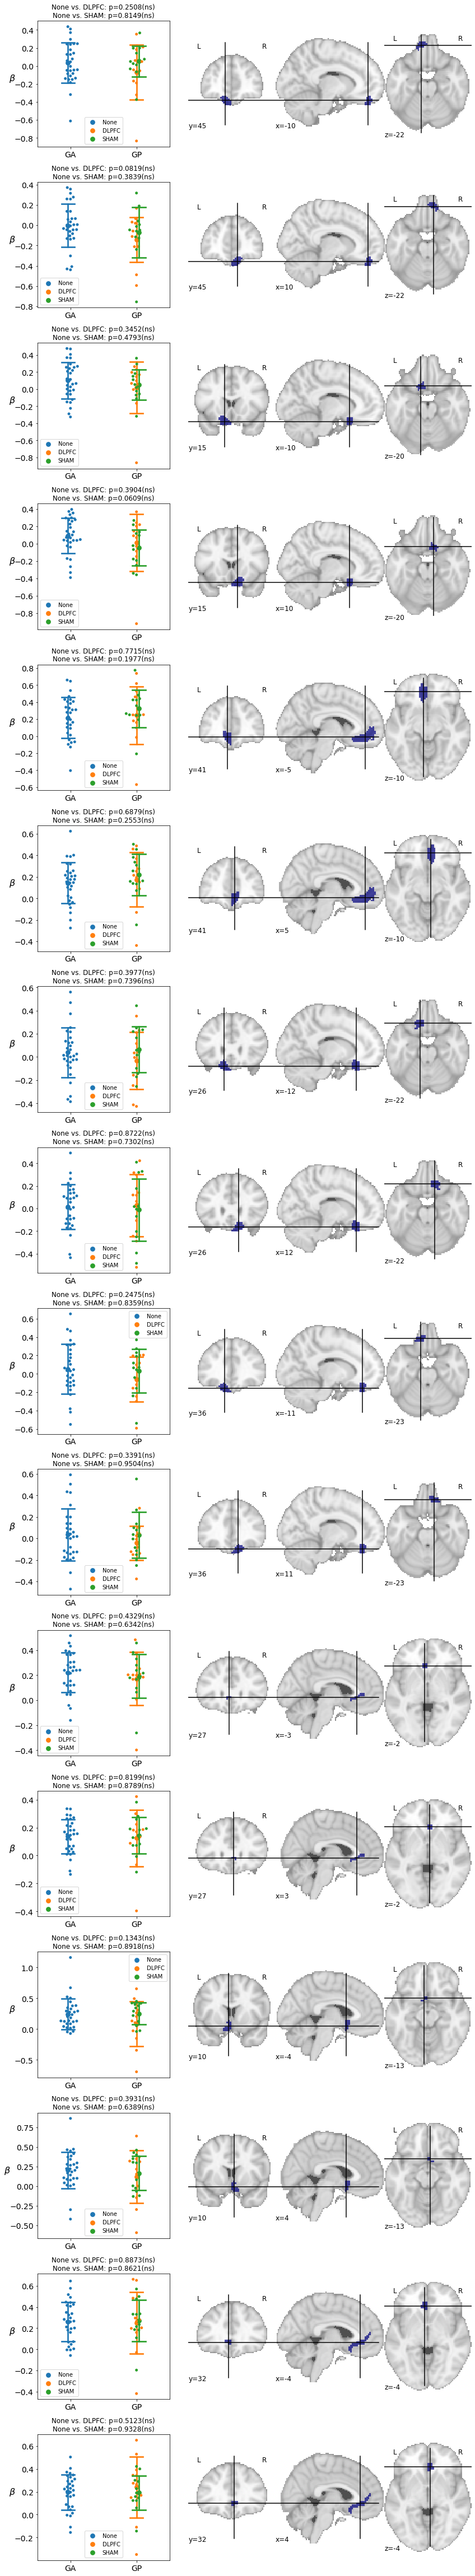

In [18]:
nrows, ncols = len(masker.labels), 3
fig = plt.figure(figsize=(ncols*4, nrows*4), constrained_layout=False)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
for row in range(nrows):
    axs.append(fig.add_subplot(gs[row,0]))
    axs.append(fig.add_subplot(gs[row,1:3]))

for ii, y in enumerate(masker.labels):
    pass_=True
    title=[]
    tval, pval = stats.ttest_ind(dh[dh.TMS=='None'][y], dh[dh.TMS=='DLPFC'][y])
    title.append('None vs. DLPFC: p=%.4f(%s)'%(pval, convert_pvalue_to_asterisks(pval)))
    if pval < 0.05:
        pass_ = False
    tval, pval = stats.ttest_ind(dh[dh.TMS=='None'][y], dh[dh.TMS=='SHAM'][y])
    title.append('None vs. SHAM: p=%.4f(%s)'%(pval, convert_pvalue_to_asterisks(pval)))
    if pval < 0.05:
        pass_ = False
#     if pass_:
#         continue

    ax = axs[2*ii]
    ax = sns.pointplot(
        data=dh, x='class', y=y, hue='TMS'
        , dodge=True
        , capsize=0.2, ci='sd'
        , ax=ax
    )
    ax = sns.swarmplot(
        data=dh, x='class', y=y, hue='TMS'
        , ax=ax
    )
    ax.legend(ax.get_legend_handles_labels()[0][:3], ax.get_legend_handles_labels()[1][:3])
    ax.set(xlabel='', title='%s\n%s'%(title[0],title[1]))
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel(r'$\beta$', fontsize=16, rotation=0)

fig.tight_layout()

for ii, y in enumerate(masker.labels):
    roi = nilearn.image.math_img(img1=img_mask, formula='img1==%d'%int(y))
    nilearn.plotting.plot_roi(roi, axes=axs[2*ii+1])

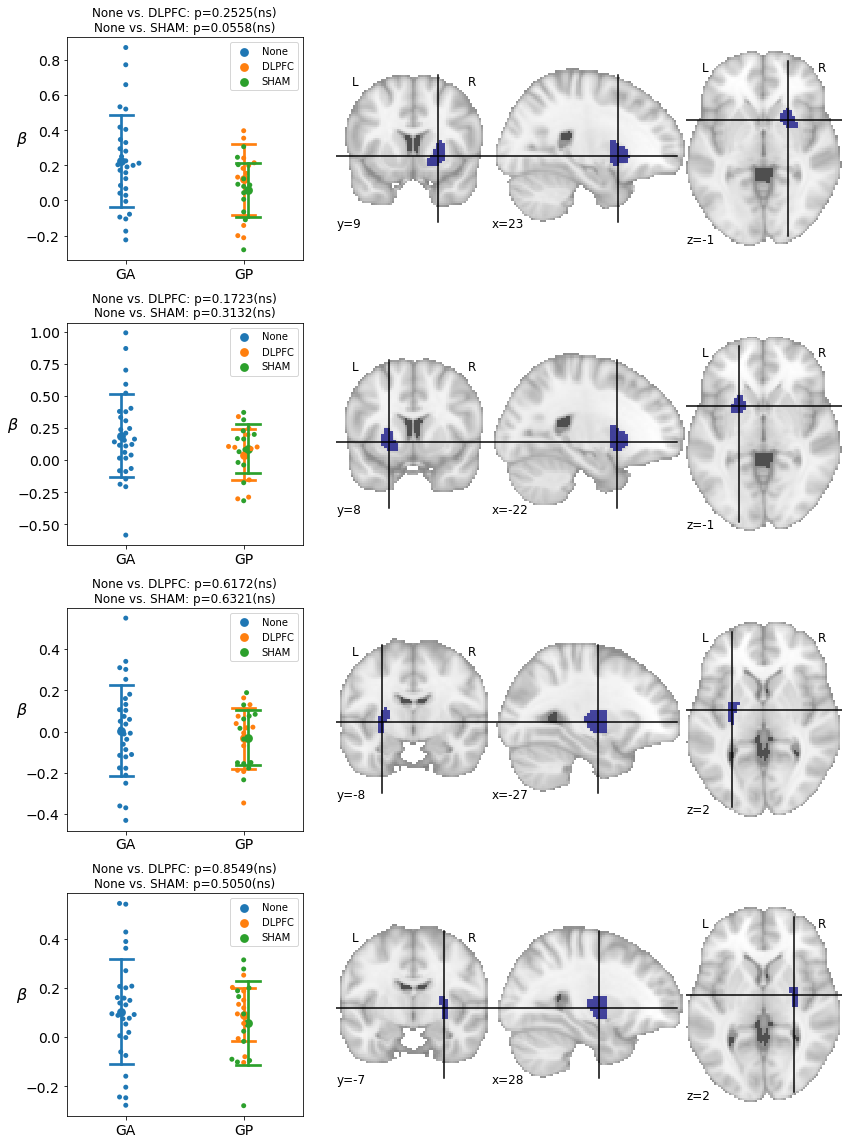

In [21]:
nrows, ncols = len(masker.labels), 3
fig = plt.figure(figsize=(ncols*4, nrows*4), constrained_layout=False)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
for row in range(nrows):
    axs.append(fig.add_subplot(gs[row,0]))
    axs.append(fig.add_subplot(gs[row,1:3]))

for ii, y in enumerate(masker.labels):
    pass_=True
    title=[]
    tval, pval = stats.ttest_ind(dh[dh.TMS=='None'][y], dh[dh.TMS=='DLPFC'][y])
    title.append('None vs. DLPFC: p=%.4f(%s)'%(pval, convert_pvalue_to_asterisks(pval)))
    if pval < 0.05:
        pass_ = False
    tval, pval = stats.ttest_ind(dh[dh.TMS=='None'][y], dh[dh.TMS=='SHAM'][y])
    title.append('None vs. SHAM: p=%.4f(%s)'%(pval, convert_pvalue_to_asterisks(pval)))
    if pval < 0.05:
        pass_ = False
#     if pass_:
#         continue

    ax = axs[2*ii]
    ax = sns.pointplot(
        data=dh, x='class', y=y, hue='TMS'
        , dodge=True
        , capsize=0.2, ci='sd'
        , ax=ax
    )
    ax = sns.swarmplot(
        data=dh, x='class', y=y, hue='TMS'
        , ax=ax
    )
    ax.legend(ax.get_legend_handles_labels()[0][:3], ax.get_legend_handles_labels()[1][:3])
    ax.set(xlabel='', title='%s\n%s'%(title[0],title[1]))
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel(r'$\beta$', fontsize=16, rotation=0)

fig.tight_layout()

for ii, y in enumerate(masker.labels):
    roi = nilearn.image.math_img(img1=img_mask, formula='img1==%d'%int(y))
    nilearn.plotting.plot_roi(roi, axes=axs[2*ii+1])

---

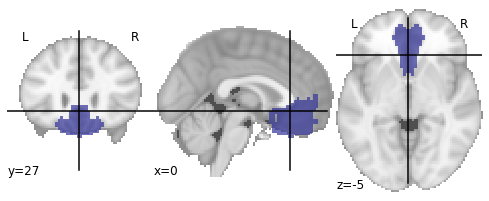

In [15]:
# img_mask = img_Putamen
img_mask = img_VmPFC
nilearn.plotting.plot_roi(
    img_mask
    , cmap='terrain'
    , cut_coords=(0, 27,-5)
)

In [29]:
img_VmPFC = nilearn.image.load_img(img_VmPFC)
nVmPFC = img_VmPFC.get_data().sum()
nVmPFC

/tmp/ipykernel_444026/1672623866.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  nVmPFC = img_VmPFC.get_data().sum()


2158

In [17]:
## p=0.001 (two-tailed) of z-test
threshold = 3.2905

In [27]:
betas = {}
df = pd.DataFrame(columns=['subj', 'group', 'nvoxels'])
## DLPFC
for nn in list_DLPFC:
    subj = 'GP'+nn
    tmp = masking.apply_mask(
        imgs='/mnt/ext6/GP/fmri_data/stats/AM/reward/%s/%s.rwdtm#2_Tstat.tlrc.nii'%(subj,subj)
        , mask_img=img_VmPFC
    )
    betas[(subj,'DLPFC')] = tmp
    nvoxels = (tmp>threshold).sum()
    df = df.append({'subj':subj, 'group':'DLPFC', 'nvoxels':nvoxels}, ignore_index=True)
## SHAM
for nn in list_SHAM:
    subj = 'GP'+nn
    tmp = masking.apply_mask(
        imgs='/mnt/ext6/GP/fmri_data/stats/AM/reward/%s/%s.rwdtm#2_Tstat.tlrc.nii'%(subj,subj)
        , mask_img=img_VmPFC
    )
    betas[(subj,'SHAM')] = tmp
    nvoxels = (tmp>threshold).sum()
    df = df.append({'subj':subj, 'group':'SHAM', 'nvoxels':nvoxels}, ignore_index=True)
df

,subj,group,nvoxels
0,GP09,DLPFC,340
1,GP10,DLPFC,556
2,GP18,DLPFC,0
3,GP21,DLPFC,314
4,GP22,DLPFC,839
5,GP24,DLPFC,948
6,GP27,DLPFC,402
7,GP34,DLPFC,18
8,GP35,DLPFC,179
9,GP36,DLPFC,932


In [39]:
for voxel in range(nVmPFC):
    a = []
    for subj in list_DLPFC:
        a.append(betas[('GP'+subj, 'DLPFC')][voxel])
    b = []
    for subj in list_SHAM:
        b.append(betas[('GP'+subj, 'SHAM')][voxel])
    tval, pval = stats.ttest_ind(a,b)
    if pval < 1.e-2:
        print(voxel, tval, pval)

1584 -2.9369306857417707 0.007876353015470648


3.2905


Ttest_indResult(statistic=0.5268777311956214, pvalue=0.6038001973734457)

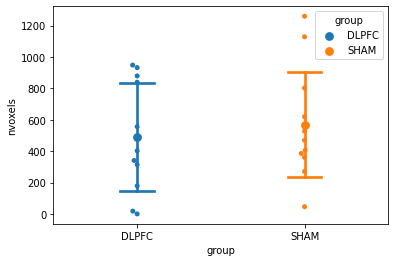

In [29]:
print(threshold)
sns.pointplot(data=df, x='group', y='nvoxels', hue='group', capsize=0.2, ci='sd')
sns.swarmplot(data=df, x='group', y='nvoxels')

stats.ttest_ind(df[df.group=='SHAM'].nvoxels, df[df.group=='DLPFC'].nvoxels)

---

In [18]:
df = pd.DataFrame(columns=['group', 'nvoxels'])
dg1 = pd.DataFrame()
dg2 = pd.DataFrame()
# subbrick = 'beta_mean'
subbrick = 'zscore'
idx = 0 if subbrick=='beta_mean' else (1 if subbrick=='zscore' else 'invalid')

## DLPFC
group_dlfpc = masking.apply_mask(
    imgs='/mnt/ext6/GP/fmri_data/stats/AM/reward/rwdtm-2_Coef.group.DLPFC.nii'
    , mask_img=img_VmPFC
)[idx,0]
nvoxels = (group_dlfpc>threshold).sum()
df = df.append({'group':'DLPFC', 'nvoxels':nvoxels}, ignore_index=True)
dg1['Zscore'] = group_dlfpc
dg1['group'] = 'DLPFC'
## SHAM
group_sham = masking.apply_mask(
    imgs='/mnt/ext6/GP/fmri_data/stats/AM/reward/rwdtm-2_Coef.group.Sham.nii'
    , mask_img=img_VmPFC
)[idx,0]
nvoxels = (group_sham>threshold).sum()
df = df.append({'group':'SHAM', 'nvoxels':nvoxels}, ignore_index=True)
dg2['Zscore'] = group_sham
dg2['group'] = 'SHAM'

df

,group,nvoxels
0,DLPFC,0
1,SHAM,219


In [19]:
dg = pd.merge(dg1, dg2, how='outer', on=None)
dg

,Zscore,group
0,-0.724220,DLPFC
1,-0.530536,DLPFC
2,-0.836035,DLPFC
3,-0.546677,DLPFC
4,-0.618615,DLPFC
...,...,...
4311,1.111644,SHAM
4312,-0.245493,SHAM
4313,1.824971,SHAM
4314,0.349201,SHAM
